# Homework 7 - Part B

*Note that there are two different notebooks for HW assignment 7. This is part A. There will be two different assignments in gradescope for each part. The deadlines are the same for both parts.*

## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [177]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str | None = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [178]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

## Problem 1  - Bayesian Linear regression on steroids 

The purpose of this problem is to demonstrate that we have learned enough to do very complicated things.
In the first part, we will do Bayesian linear regression with radial basis functions (RBFs) in which we characterize the posterior of all parameters, including the length-scales of the RBFs.
In the second part, we are going to build a model that has an input-varying noise. Such models are called heteroscedastic models. 

We need to write some `pytorch` code to compute the design matrix. This is absolutely necessary so that `pyro` can differentiate through all expressions.

In [179]:
class RadialBasisFunctions(torch.nn.Module):
    """Radial basis functions basis.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed length scale.
    """
    def __init__(self, X, ell):
        super().__init__()
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def forward(self, x):
        distances = torch.cdist(x, self.X)
        return torch.exp(-.5 * distances ** 2 / self.ell ** 2)

Here is how you can use them:

In [180]:
# Make the basis
x_centers = torch.linspace(-1, 1, 10).unsqueeze(-1)
ell = 0.2
basis = RadialBasisFunctions(x_centers, ell)

# Some points (need to be N x 1)
x = torch.linspace(-1, 1, 100).unsqueeze(-1)

# Evaluate the basis
Phi = basis(x)

# Here is the shape of Phi
print(Phi.shape)

torch.Size([100, 10])


Here is how they look like:

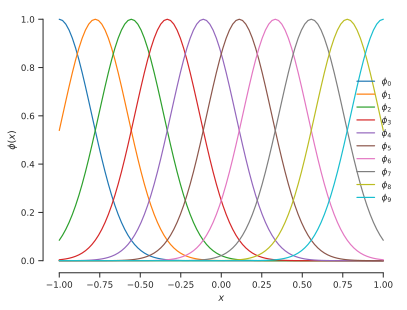

In [181]:
fig, ax = plt.subplots()
for i in range(Phi.shape[1]):
    ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
ax.set(xlabel="$x$", ylabel="$\phi(x)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part A - Hierarchical Bayesian linear regression with input-independent noise

We will analyze the motorcycle dataset. The data is loaded below.

In [182]:
# url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
# download(url)

We will work with the scaled data:

In [183]:
scaler.transform([[0, 3.7, 0, 0]])

array([[-1.86593724,  0.50648294, -3.35807757, -1.6083214 ]])

In [184]:
data[0]

array([2.4, 0. , 1. , 3.7])

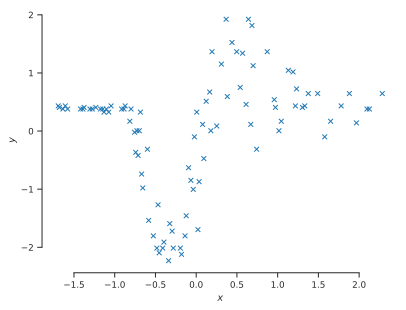

In [185]:
from sklearn.preprocessing import StandardScaler

data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)

fig, ax = plt.subplots()
ax.plot(X, Y, 'x')
ax.set(xlabel="$x$", ylabel="$y$")
sns.despine(trim=True);

### Part A.I

Your goal is to implement the model described below.
We use the radial basis functions (`RadialBasisFunction`) with centers, $x_i$ at $m=50$ equidistant points between the minimum and maximum of the observed inputs:

$$
\phi_i(x;\ell) = \exp \left( - \frac{(x - x_i)^2}{2 \ell^2} \right),
$$

for $i=1,\dots,m$.
We denote the vector of RBFs evaluated at $x$ as $\boldsymbol{\phi}(x;\ell)$.

We are not going to pick the length-scales $\ell$ by hand. Instead, we will put a prior on it:

$$
\ell \sim \text{Exponential}(1).
$$

The corresponding weights have priors:

$$
w_j | \alpha_i \sim N(0, \alpha_j^2),
$$

and its $\alpha_j$ has a prior:

$$
\alpha_j \sim \text{Exponential}(1),
$$

for $j=1,\dots,m$.

Denote our data as:

$$
x_{1:n} = (x_1, \dots, x_n)^T,\;\text{(inputs)},
$$

and

$$
y_{1:n} = (y_1, \dots, y_n)^T,\;\text{(outputs)}.
$$

The likelihood of the data is:

$$
y_i | \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2),
$$

for $i=1,\dots,n$.

$$
y_n | \ell, \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_n;\ell), \sigma^2).
$$

Complete the `pyro` implementation of that model:

**Answer:**

In [186]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        # Notice below that dist.Normal needs the standard deviation - not the variance
        # We follow a different convention in the lecture notes
        w = pyro.sample("w", dist.Normal(0.0, alpha))
    # TODO Check this
    ell = pyro.sample("ell", dist.Exponential(1.0)) # Complete the code assign to ell the correct prior distribution (an Exponential(1)).
    # Hint: Look at alpha.
    # TODO check this
    sigma = pyro.sample("sigma", dist.Exponential(1.0)) # Complete the code assign to sigma the correct prior distribution (an Exponential(1))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma), obs=y)
    # Notice that I'm making the model return all the variables that I have made.
    # This is not essential for characterizing the posterior, but it does reduce redundant code
    # when we are trying to get the posterior predictive.
    return locals()

The graph will help to understand the model:

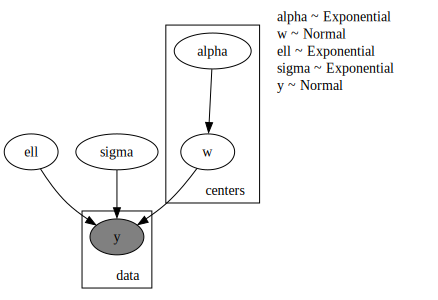

In [187]:
pyro.render_model(model, (X, Y), render_distributions=True)

Use `pyro.infer.autoguide.AutoDiagonalNormal` to make the guide:

In [188]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

We will use variational inference. Here is the training code from the hans-on activity:

In [189]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.
    
    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 1_000 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

### Part A.II

Train the model for 20,000 iterations. Call the `train()` function we defined above to do it.
Make sure you store the returned elbo values because you will need them later.

**Answer:**

In [190]:
n_iter = 20_000
elbos, params = train(model, guide, (X, Y), num_iter=n_iter)

Iteration: 0 Loss: 363.5799255371094


Iteration: 1000 Loss: 200.8079833984375
Iteration: 2000 Loss: 152.5554656982422
Iteration: 3000 Loss: 126.14318084716797
Iteration: 4000 Loss: 118.61347198486328
Iteration: 5000 Loss: 132.83177185058594
Iteration: 6000 Loss: 129.54481506347656
Iteration: 7000 Loss: 138.88003540039062
Iteration: 8000 Loss: 132.2635955810547
Iteration: 9000 Loss: 129.59344482421875
Iteration: 10000 Loss: 124.4887466430664
Iteration: 11000 Loss: 127.14247131347656
Iteration: 12000 Loss: 130.12098693847656
Iteration: 13000 Loss: 128.5816192626953
Iteration: 14000 Loss: 125.92719268798828
Iteration: 15000 Loss: 133.81747436523438
Iteration: 16000 Loss: 136.46102905273438
Iteration: 17000 Loss: 130.19757080078125
Iteration: 18000 Loss: 142.46568298339844
Iteration: 19000 Loss: 122.4692153930664


### Part A.III

Plot the evolution of the ELBO.

**Answer:**

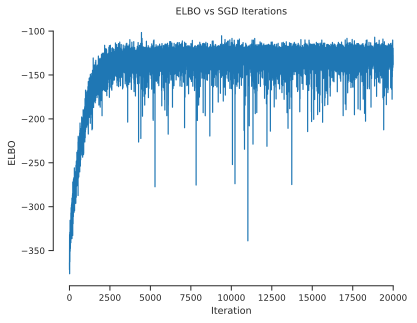

In [191]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel='Iteration', ylabel='ELBO', title='ELBO vs SGD Iterations')
sns.despine(trim=True);

### Part A.IV

Take 1,000 posterior samples.

**Answer:**

I'm giving you this one because it is a bit tricky. You need to use the `pyro.infer.Predictive` class to do it. Here is how you can use it:

In [192]:
post_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1000)(X, Y)
# Just modify the call to get the right number of samples

### Part A.V

Plot the histograms of the posteriors of $\ell$, $\sigma$, $\alpha_{10}$ and $w_{10}$.

**Answer:**

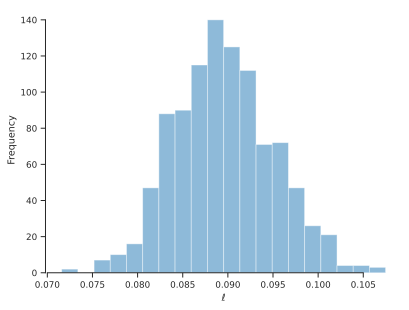

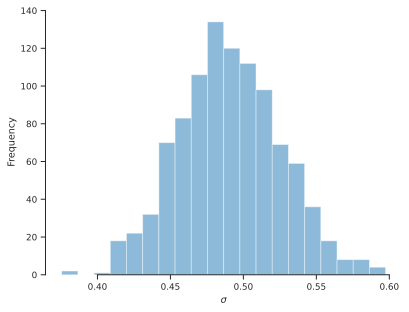

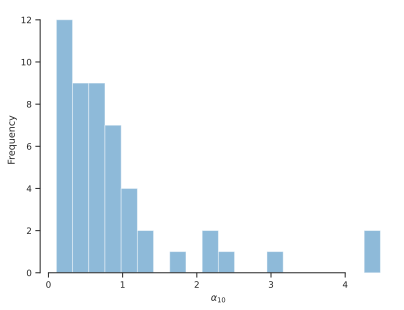

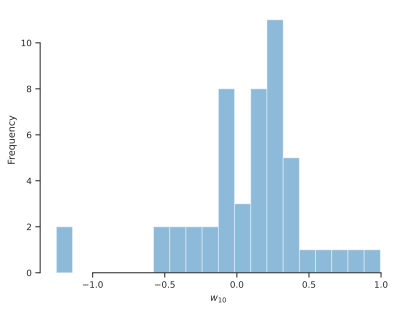

In [193]:
# First, here is how to extract the samples.
ell = post_samples["ell"]
# You can do `post_samples.keys()` to see all the keys.
# But they should correspond to the names of the latent variables in the model.
sigma = post_samples["sigma"]
alphas = post_samples["alpha"]
ws = post_samples["w"]

# Here is the code to make the histogram for the length scale.
fig, ax = plt.subplots()
# fig.set_size_inches(10, 8)
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(ell.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\ell$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(sigma.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\sigma$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(alphas[9].detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\alpha_{10}$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(ws[9].detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$w_{10}$", ylabel="Frequency")
sns.despine(trim=True);

### Part A.VI

Let's extend the model to make predictions.

**Answer:**

In [194]:
# Again, I'm giving you most of the code here.

def predictive_model(X, y, num_centers=50):
    # First we run the original model get all the variables
    params = model(X, y, num_centers)
    # Here is how you can access the variables
    w = params["w"]
    ell = params["ell"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    # Here are the points where we want to make predictions
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    # Evaluate the basis on the prediction points
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    # Make the predictions - we use a deterministic node here because we want to
    # save the results of the predictions.
    predictions = pyro.deterministic("predictions", Phi @ w)
    # Finally, we add the measurement noise
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part A.VII

Extract the posterior predictive distribution using 10,000 samples. Separate aleatory and epistemic uncertainty.

**Answer:**

In [195]:
n_post_samples = 10_000
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=n_post_samples)(X, Y)
# We will predict here:
# NOTE: added .item() here; remove if it causes issues
xs = torch.linspace(X.min().item(), X.max().item(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"]
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

### Part A.VIII

Plot the data, the median, the 95% credible interval of epistemic uncertainty and the 95% credible interval of aleatory uncertainty, along with five samples from the posterior.

**Answer:**

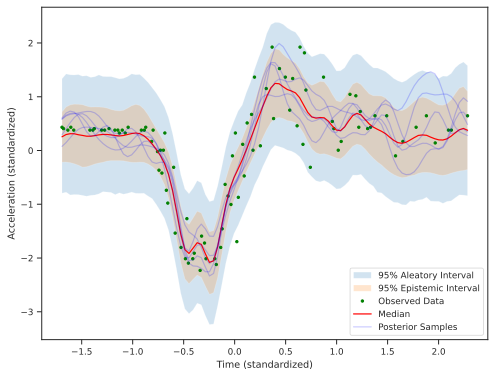

In [196]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.fill_between(xs.flatten(), ap_025.flatten(), ap_975.flatten(), alpha=0.2, label=r"95% Aleatory Interval")
ax.fill_between(xs.flatten(), p_025.flatten(), p_975.flatten(), alpha=0.2, label=r"95% Epistemic Interval")
ax.plot(X, Y, 'g.', label="Observed Data")
ax.plot(xs, p_500.flatten(), 'r', label="Median")

n_plotted_samples = 5
i_samples = np.random.randint(0, n_post_samples, n_plotted_samples)
for (j, i) in enumerate(i_samples):
    ax.plot(xs.flatten(), predictions[i].flatten(), 'b', alpha=0.2, label="Posterior Samples" if j == 0 else None)

ax.set_xlabel("Time (standardized)")
ax.set_ylabel("Acceleration (standardized)")

ax.legend(loc="lower right");

### Part B - Heteroscedastic regression

We are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.
Here I will let you do more of the work.

Everything is as before for $\ell$, the $\alpha_j$'s, and the $w_j$'s.
We now introduce a model for the noise that is input dependent.
It will use the same RBFs as the mean function.
But let's use a different length-scale, $\ell_\sigma$.
So, we add:

$$
\ell_\sigma \sim \text{Exponential}(1),
$$

$$
\alpha_{\sigma,j} \sim \text{Exponential}(1),
$$

and

$$
w_{\sigma,j} | \alpha_{\sigma,j} \sim N(0, \alpha_{\sigma,j}^2),
$$

for $j=1,\dots,m$.

Our model for the input-dependent noise variance is:

$$
\sigma(x;\mathbf{w}_\sigma,\ell) = \exp\left(\mathbf{w}_\sigma^T \boldsymbol{\phi}(x;\ell_\sigma)\right).
$$

So, the likelihood of the data is:

$$
y_i | \mathbf{w}, \mathbf{w}_\sigma \sim N\left(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2(x_i;\mathbf{w}_\sigma,\ell)\right),
$$

You will implement this model.

### Part B.I

Complete the code below:

In [197]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        # Let's add the generalized linear model for the log noise.
        alpha_noise = pyro.sample("alpha_noise", dist.Exponential(1.0))
        w_noise = pyro.sample("w_noise", dist.Normal(0.0, alpha_noise))
    ell = pyro.sample("ell", dist.Exponential(1.0))
    ell_noise = pyro.sample("ell_noise", dist.Exponential(1.0))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(X)

    # This is the new part 2/2
    model_mean = Phi @ w
    sigma = torch.exp(Phi_noise @ w_noise) # Your code here (torch.exp(<something>))
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(model_mean, sigma), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [198]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

Make the graph of the model using `pyro` functionality:

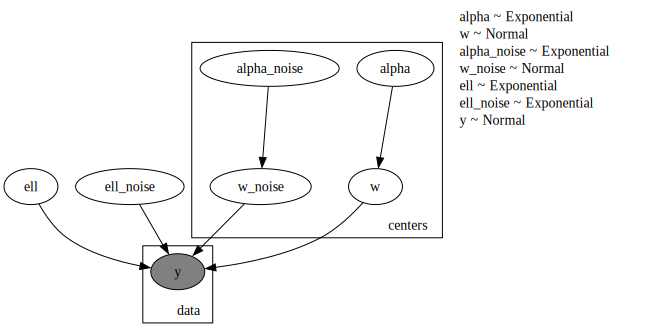

In [199]:
pyro.render_model(model, (X, Y), render_distributions=True)

### Part B.II

Train the model using 20,000 iterations. Then plot the evolution of the ELBO.

**Answer:**

In [200]:
n_iter = 20_000
elbos, params = train(model, guide, (X, Y), num_iter=n_iter)

Iteration: 0 Loss: 1680.6708984375
Iteration: 1000 Loss: 326.7957458496094
Iteration: 2000 Loss: 253.4070587158203
Iteration: 3000 Loss: 218.51524353027344
Iteration: 4000 Loss: 202.29750061035156
Iteration: 5000 Loss: 184.5311737060547
Iteration: 6000 Loss: 190.16201782226562
Iteration: 7000 Loss: 178.9602508544922
Iteration: 8000 Loss: 174.08782958984375
Iteration: 9000 Loss: 174.0884246826172
Iteration: 10000 Loss: 172.80557250976562
Iteration: 11000 Loss: 187.49974060058594
Iteration: 12000 Loss: 175.96047973632812
Iteration: 13000 Loss: 166.39564514160156
Iteration: 14000 Loss: 158.0024871826172
Iteration: 15000 Loss: 163.67138671875
Iteration: 16000 Loss: 159.4533233642578
Iteration: 17000 Loss: 159.23187255859375
Iteration: 18000 Loss: 175.60989379882812
Iteration: 19000 Loss: 174.4525909423828


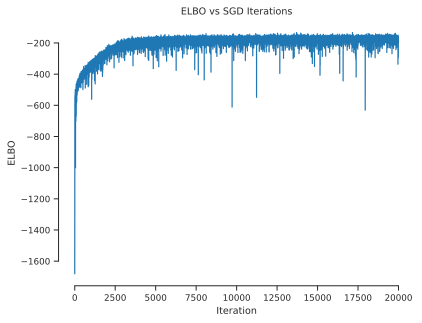

In [201]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel='Iteration', ylabel='ELBO', title='ELBO vs SGD Iterations')
sns.despine(trim=True);

### Part B.III

Extend the model to make predictions.

**Answer:**

In [202]:
def predictive_model(X, y, num_centers=50):
    params = model(X, y, num_centers)
    w = params["w"]
    w_noise = params["w_noise"]
    ell = params["ell"]
    ell_noise = params["ell_noise"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = pyro.deterministic("sigma", torch.exp(Phi_noise @ w_noise))
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part B.IV

Now, make predictions and calculate the epistemic and aleatory uncertainties as in part A.VII.

**Answer:**

In [203]:
n_post_samples = 10_000
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=n_post_samples)(X, Y)
xs = torch.linspace(X.min().item(), X.max().item(), 100).unsqueeze(-1)
predictions = post_pred["predictions"]
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
predictions_with_noise = post_pred["predictions_with_noise"]
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

### Part B.V

Make the same plot as in part A.VIII.

**Answer:**

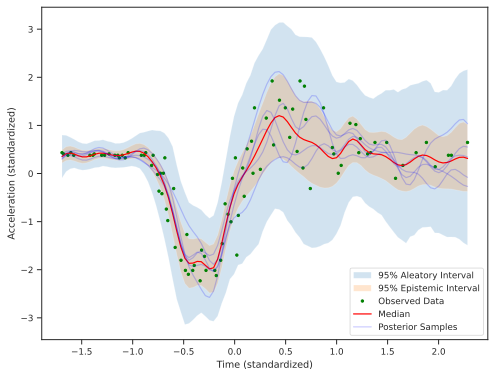

In [204]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.fill_between(xs.flatten(), ap_025.flatten(), ap_975.flatten(), alpha=0.2, label=r"95% Aleatory Interval")
ax.fill_between(xs.flatten(), p_025.flatten(), p_975.flatten(), alpha=0.2, label=r"95% Epistemic Interval")
ax.plot(X, Y, 'g.', label="Observed Data")
ax.plot(xs, p_500.flatten(), 'r', label="Median")

n_plotted_samples = 5
i_samples = np.random.randint(0, n_post_samples, n_plotted_samples)
for (j, i) in enumerate(i_samples):
    ax.plot(xs.flatten(), predictions[i].flatten(), 'b', alpha=0.2, label="Posterior Samples" if j == 0 else None)

ax.set_xlabel("Time (standardized)")
ax.set_ylabel("Acceleration (standardized)")

ax.legend(loc="lower right");

### Part B.VI

Plot the estimated noise standard deviation as a function of of the input along with a 95% credible interval.

**Answer:**

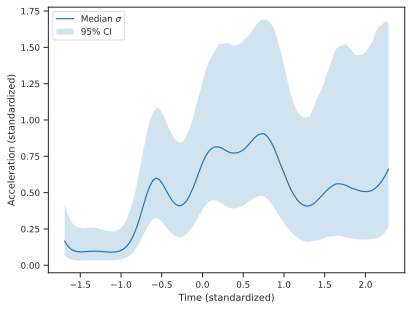

In [205]:
sigma_025, sigma_500, sigma_975 = np.percentile(post_pred["sigma"], [2.5, 50, 97.5], axis=0)

fig, ax = plt.subplots()
ax.plot(xs.flatten(), sigma_500.flatten(), label=r"Median $\sigma$")
ax.fill_between(xs.flatten(), sigma_025.flatten(), sigma_975.flatten(), alpha=0.2, label="95% CI")

ax.set_xlabel("Time (standardized)")
ax.set_ylabel("Acceleration (standardized)")

ax.legend(loc="upper left");

### Part B.VII

Which model do you prefer? Why?

**Answer:**  
Which model is "better" really depends on whether or not the underlying data is homo- or heteroskedastic. If we look at the original `motor.dat` dataset description, we can see that the 94 data points are divided into 3 strata, and each strata has a unique variance residual estimate. So, we expect to have varying noise levels throughout the dataset. For this reason, I prefer the heteroskedastic model, because it is more able to capture the varying noise levels over time. If we look at the original dataset, we see that the first stratum has a low variance residual, the middle one has a higher value, and the final stratum lies somewhere between the first two. We can see this general shape in the graph above.

### Part B.IX

Can you think of any way to improve the model?
Go crazy! This is the last homework assignment!
There is no right or wrong answer here.
But if you have a good idea, we will give you extra credit.

We would like to incorporate our prior knowledge about the variance of the data that is included in the original dataset. The variance data has been stratified, and we have 3 strata with 3 unique variance estimates. We can use the mean and variance of these data to better inform our prior that we set on the ell_variance. Since the values are replicated throughout each stratum, they will naturally be weighted based on how many points are in each stratum. We will convert the residual variances to standard deviations first so that we have the same units as our acceleration values, and we can calculate the mean and variance of those data to inform a Gamma distribution for the prior on our noise using the following relations between the mean, variance, $\alpha$, and $\beta$ values:
$$
\frac{\alpha}{\beta} = \mu \\
$$
        
$$
\frac{\alpha}{\beta^2} = \sigma^2
$$

To begin with, though, we need to convert our raw variance values into standard deviations to get them in the same units as the raw acceleration values and then we can transform those into the standardized units using the same `scaler` we used earlier.

In [206]:
raw_data = np.loadtxt('motor.dat')
raw_variances = raw_data[:, 3]
raw_stds = np.sqrt(raw_variances)

fake_data = np.zeros_like(raw_data)
# Place our std values into the same row as the accelerations so they get the same transform
fake_data[:, 1] = raw_stds
stds = scaler.transform(fake_data)[:, 1] # type: ignore

mean_std = stds.mean()
var_std = stds.var()

beta = mean_std / var_std
alpha = mean_std * beta

output_std_gamma = dist.Gamma(alpha, beta)

Let's check the gamma against a histogram of the raw data

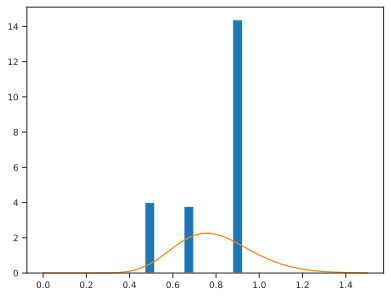

In [207]:
fig, ax = plt.subplots()
ax.hist(stds, density=True)
samples = np.linspace(0, 1.5)

# To get the pdf, we need to use log_prob and take the exponential of it
ax.plot(samples, torch.exp(output_std_gamma.log_prob(torch.tensor(samples))));

Seems reasonable! Now, we can use this in our definition of the model's noise and proceed with the same process as before.

In [208]:
def model(X, y, num_centers=94):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        sigma = pyro.sample("sigma", output_std_gamma)
    ell = pyro.sample("ell", dist.Exponential(1.0))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)

    # This is the new part 2/2
    model_mean = Phi @ w
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(model_mean, sigma), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [209]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

Make the graph of the model using `pyro` functionality:

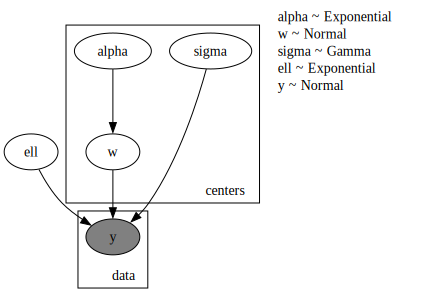

In [210]:
pyro.render_model(model, (X, Y), render_distributions=True)

In [211]:
n_iter = 20_000
elbos, params = train(model, guide, (X, Y), num_iter=n_iter)

Iteration: 0 Loss: 574.43017578125
Iteration: 1000 Loss: 300.9743347167969
Iteration: 2000 Loss: 232.74118041992188
Iteration: 3000 Loss: 190.5000762939453
Iteration: 4000 Loss: 197.02261352539062
Iteration: 5000 Loss: 202.42433166503906
Iteration: 6000 Loss: 181.80178833007812
Iteration: 7000 Loss: 197.49391174316406
Iteration: 8000 Loss: 187.9004364013672
Iteration: 9000 Loss: 185.24667358398438
Iteration: 10000 Loss: 196.54412841796875
Iteration: 11000 Loss: 202.05955505371094
Iteration: 12000 Loss: 180.61251831054688
Iteration: 13000 Loss: 172.61004638671875
Iteration: 14000 Loss: 157.88064575195312
Iteration: 15000 Loss: 177.56594848632812
Iteration: 16000 Loss: 185.67352294921875
Iteration: 17000 Loss: 196.6785888671875
Iteration: 18000 Loss: 174.81521606445312
Iteration: 19000 Loss: 168.70281982421875


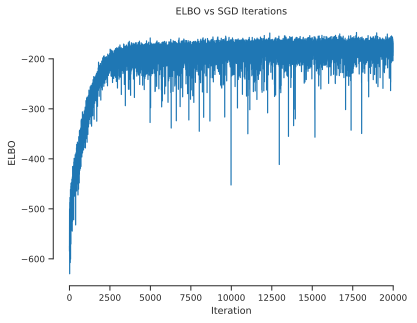

In [212]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel='Iteration', ylabel='ELBO', title='ELBO vs SGD Iterations')
sns.despine(trim=True);

In [213]:
def predictive_model(X, y, num_centers=94):
    params = model(X, y, num_centers)
    w = params["w"]
    ell = params["ell"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 94).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = params["sigma"]
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

In [214]:
n_post_samples = 10_000
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=n_post_samples)(X, Y)
xs = torch.linspace(X.min().item(), X.max().item(), 94).unsqueeze(-1)
predictions = post_pred["predictions"]
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
predictions_with_noise = post_pred["predictions_with_noise"]
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

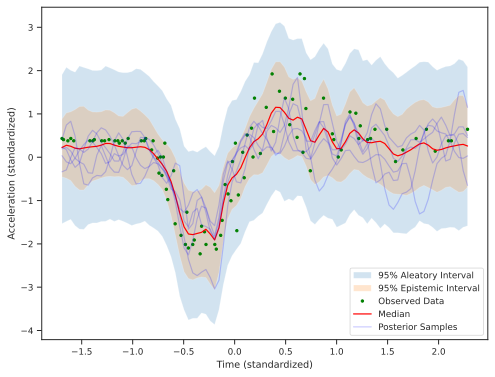

In [215]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.fill_between(xs.flatten(), ap_025.flatten(), ap_975.flatten(), alpha=0.2, label=r"95% Aleatory Interval")
ax.fill_between(xs.flatten(), p_025.flatten(), p_975.flatten(), alpha=0.2, label=r"95% Epistemic Interval")
ax.plot(X, Y, 'g.', label="Observed Data")
ax.plot(xs, p_500.flatten(), 'r', label="Median")

n_plotted_samples = 5
i_samples = np.random.randint(0, n_post_samples, n_plotted_samples)
for (j, i) in enumerate(i_samples):
    ax.plot(xs.flatten(), predictions[i].flatten(), 'b', alpha=0.2, label="Posterior Samples" if j == 0 else None)

ax.set_xlabel("Time (standardized)")
ax.set_ylabel("Acceleration (standardized)")

ax.legend(loc="lower right");